## 1. Import Statements

In [73]:
import io, zipfile, requests, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap



from scipy.stats.mstats import winsorize
from IPython.display import display

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve

## 2. Fetching the Dataset from URL

In [2]:
BASE = "https://www.sec.gov/files/dera/data/financial-statement-data-sets"
UA   = {"User-Agent": "Bankruptcy-Prediction-Using-Financial-Ratios (shreyassrikanth997@gmail.com)"}  # REQUIRED
OUT  = Path("sec_ratios_2020_2024"); OUT.mkdir(exist_ok=True)

# Forms to include (annual + quarterly)
FORMS = {"10-K","10-K/A","10-Q","10-Q/A"}

In [3]:
# --- Financial Tags Needed to Compute Ratios ---
# These tags are numeric line-items from num.txt in SEC FSDS.
# They are used to compute liquidity, leverage, profitability ratios, etc.

TAGS = {
    "Assets",
    "Liabilities",
    "StockholdersEquity",
    "AssetsCurrent",
    "LiabilitiesCurrent",
    "CashAndCashEquivalentsAtCarryingValue",
    "Revenues",
    "SalesRevenueNet",
    "NetIncomeLoss",
    "OperatingIncomeLoss",
    # Optional: included only if they exist in a filing
    "InterestExpense",
    "InventoryNet",
}

# Years to download: 2020–2024
YEARS = range(2020, 2025)

In [4]:
def read_tab_or_pipe(fh, usecols=None, is_num=False):
    """
    Try to read SEC text files that may be pipe- or tab-separated.
    Falls back to fixed-width if needed.
    """
    for sep in (r"\t|\|", "\t", "|"):
        try:
            fh.seek(0)
            return pd.read_csv(
                fh,
                sep=sep,
                engine="python",
                dtype=str,
                usecols=usecols,
                on_bad_lines=("skip" if is_num else "error"),
            )
        except Exception:
            pass

    # Last resort: fixed-width
    fh.seek(0)
    return pd.read_fwf(fh, dtype=str)

In [5]:
files = []

for y in YEARS:
    for q in (1, 2, 3, 4):
        url = f"{BASE}/{y}q{q}.zip"
        r = requests.get(url, headers=UA, timeout=60)

        if not r.ok:
            print(f"skip {y}Q{q}")
            continue

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            names = set(z.namelist())

            # Require sub.txt (filing metadata) and num.txt (numeric facts)
            if not {"sub.txt", "num.txt"}.issubset(names):
                print(f"missing files {y}Q{q}")
                continue

            # ---- Load SUB (metadata) ----
            sub = read_tab_or_pipe(z.open("sub.txt"))
            sub.columns = [c.lower().strip() for c in sub.columns]

            if not {"adsh", "form"}.issubset(sub.columns):
                print(f"schema issue {y}Q{q}")
                continue

            sub["form"] = sub["form"].str.upper()
            sub = sub[sub["form"].isin(FORMS)].copy()  # Keep only 10-K/10-Q (+ amendments)

            if sub.empty:
                print(f"no 10K/10Q {y}Q{q}")
                continue

            adshs = set(sub["adsh"])

            # ---- Load NUM (numeric facts) ----
            usecols = ["adsh", "tag", "ddate", "qtrs", "uom", "value"]

            try:
                num = read_tab_or_pipe(
                    z.open("num.txt"),
                    usecols=usecols + ["version"],
                    is_num=True,
                )
            except Exception:
                num = read_tab_or_pipe(
                    z.open("num.txt"),
                    usecols=usecols,
                    is_num=True,
                )
                num["version"] = np.nan

            num.columns = [c.lower().strip() for c in num.columns]

            # Keep only our 10-K/10-Q filings and our chosen tags
            num = num[num["adsh"].isin(adshs)]
            num = num[num["tag"].isin(TAGS)]

            if num.empty:
                print(f"no target tags {y}Q{q}")
                continue

            # ---- Annual vs quarterly logic ----
            sub_small = sub[["adsh", "form", "cik", "name", "sic",
                             "fy", "fp", "period", "filed"]].drop_duplicates("adsh")

            num["qtrs"] = pd.to_numeric(num.get("qtrs"), errors="coerce")
            keep_adsh_annual = set(sub_small.loc[sub_small["form"].str.startswith("10-K"), "adsh"])
            keep_adsh_quarter = set(sub_small.loc[sub_small["form"].str.startswith("10-Q"), "adsh"])

            # For 10-K: keep qtrs == 4   (full year)
            # For 10-Q: keep all qtrs    (quarterly)
            num = num[
                ((num["adsh"].isin(keep_adsh_annual)) & (num["qtrs"] == 4)) |
                (num["adsh"].isin(keep_adsh_quarter))
            ]

            # ---- Prefer USD and latest date per (adsh, tag) ----
            num["is_usd"] = (num.get("uom", "").str.upper() == "USD")
            num = num.sort_values(["adsh", "tag", "is_usd", "ddate"])
            num = num.drop_duplicates(["adsh", "tag"], keep="last")

            # ---- Pivot to wide format ----
            num["value"] = pd.to_numeric(num["value"], errors="coerce")
            num = num.dropna(subset=["value"])

            wide = num.pivot(index="adsh", columns="tag", values="value").reset_index()

            # ---- Merge with metadata ----
            df = wide.merge(sub_small, on="adsh", how="left")

            # RevenuePreferred = Revenues if available, else SalesRevenueNet
            if ("Revenues" in df.columns) or ("SalesRevenueNet" in df.columns):
                df["RevenuePreferred"] = df.get("Revenues")
                if "SalesRevenueNet" in df.columns:
                    df["RevenuePreferred"] = df["RevenuePreferred"].fillna(df["SalesRevenueNet"])

            # ---- Save quarterly parquet ----
            outp = OUT / f"{y}q{q}.parquet"
            df.to_parquet(outp, index=False)
            print(f"✓ {y}Q{q}: {df.shape}")
            files.append(outp)

# ---- Combine all quarters into one file ----
if files:
    parts = [pd.read_parquet(p) for p in files]
    data = pd.concat(parts, ignore_index=True)
    data.to_parquet(OUT / "filings_2020_2024.parquet", index=False)
    print("COMBINED:", data.shape)
else:
    print("No files written.")

✓ 2020Q1: (5223, 22)
✓ 2020Q2: (5910, 22)
✓ 2020Q3: (5892, 22)
✓ 2020Q4: (5852, 22)
✓ 2021Q1: (5353, 21)
✓ 2021Q2: (6705, 22)
✓ 2021Q3: (6808, 21)
✓ 2021Q4: (6877, 21)
✓ 2022Q1: (6157, 21)
✓ 2022Q2: (7284, 21)
✓ 2022Q3: (6716, 21)
✓ 2022Q4: (6773, 21)
✓ 2023Q1: (5833, 21)
✓ 2023Q2: (6912, 21)
✓ 2023Q3: (6285, 21)
✓ 2023Q4: (6270, 21)
✓ 2024Q1: (5096, 21)
✓ 2024Q2: (6607, 21)
✓ 2024Q3: (5959, 21)
✓ 2024Q4: (5897, 21)
COMBINED: (124409, 22)


## 3. Reading the Dataset

In [6]:
# Load the combined SEC dataset created in the previous step
bankrptDF = pd.read_parquet("sec_ratios_2020_2024/filings_2020_2024.parquet")

In [7]:
# Show basic info
print("Dataset loaded successfully!")
print(f"Shape: {bankrptDF.shape[0]:,} rows × {bankrptDF.shape[1]} columns")

Dataset loaded successfully!
Shape: 124,409 rows × 22 columns


In [8]:
# Display first 10 rows in nice table format
display(bankrptDF.head())

,adsh,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,InterestExpense,InventoryNet,Liabilities,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,...,StockholdersEquity,form,cik,name,sic,fy,fp,period,filed,RevenuePreferred
0,0000002178-20-000013,NaN,NaN,NaN,636000.0,NaN,NaN,NaN,8207000.0,16099000.0,...,NaN,10-K,2178,"ADAMS RESOURCES & ENERGY, INC.",5172,2019,FY,20191231,20200306,1.811247e+09
1,0000002488-20-000008,NaN,NaN,NaN,94000000.0,NaN,NaN,NaN,341000000.0,263000000.0,...,NaN,10-K,2488,ADVANCED MICRO DEVICES INC,3674,2019,FY,20191231,20200204,NaN
2,0000002969-20-000010,1.965160e+10,4.719700e+09,2.406100e+09,18700000.0,400600000.0,7.721800e+09,1.819000e+09,3600000.0,561000000.0,...,1.155600e+10,10-Q,2969,AIR PRODUCTS & CHEMICALS INC /DE/,2810,2020,Q1,20191231,20200124,1.003500e+09
3,0000003499-20-000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60075000.0,NaN,...,NaN,10-K,3499,ALEXANDERS INC,6798,2019,FY,20191231,20200218,2.263500e+08
4,0000003545-20-000039,3.883960e+08,5.365400e+07,5.546000e+06,NaN,43288000.0,2.053810e+08,2.299200e+07,791000.0,2854000.0,...,1.944860e+08,10-Q,3545,"ALICO, INC.",0100,2020,Q1,20191231,20200206,NaN


In [9]:
# Optional: summary statistics (transpose for readability)
display(bankrptDF.describe(include='all').transpose().head(5))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
adsh,124409,124409,0000002178-20-000013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assets,92896.0,NaN,NaN,NaN,6438781230.466337,58582242177.148712,-224416000000.0,27881475.0,295856273.5,2042264500.0,4334556000000.0
AssetsCurrent,74540.0,NaN,NaN,NaN,1498861409.546268,7624636421.556354,-13620000000.0,3435271.5,102928000.0,620672500.0,343840946000.0
CashAndCashEquivalentsAtCarryingValue,75557.0,NaN,NaN,NaN,469372147.898141,5326854015.713906,-46500250.0,3096000.0,39384000.0,200700000.0,823000000000.0
InterestExpense,60644.0,NaN,NaN,NaN,100936118.695492,2473785578.966083,-2492000000.0,195976.5,3174500.0,23737000.0,496000000000.0


## 4. Feature Engineering and Data Preprocessing

## 4.1 Computing Financial Ratios

In [11]:
bankrptDF_clean = bankrptDF.copy()

numeric_cols = [
    "Assets", "AssetsCurrent", "CashAndCashEquivalentsAtCarryingValue",
    "InterestExpense", "InventoryNet", "Liabilities", "LiabilitiesCurrent",
    "NetIncomeLoss", "OperatingIncomeLoss", "StockholdersEquity",
    "Revenues", "SalesRevenueNet", "RevenuePreferred"
]

core_cols = [
    "Assets", "Liabilities", "StockholdersEquity",
    "AssetsCurrent", "LiabilitiesCurrent",
    "NetIncomeLoss", "OperatingIncomeLoss",
    "RevenuePreferred"
]

# Convert to float
for col in numeric_cols:
    if col in bankrptDF_clean.columns:
        bankrptDF_clean[col] = pd.to_numeric(bankrptDF_clean[col], errors="coerce")

## 4.2 Data Cleaning

In [12]:
print("NaN Count BEFORE core filtering:\n")
display(bankrptDF_clean[numeric_cols].isna().sum().sort_values(ascending=False))

NaN Count BEFORE core filtering:



SalesRevenueNet                          124402
InventoryNet                              88749
Revenues                                  84528
RevenuePreferred                          84521
InterestExpense                           63765
AssetsCurrent                             49869
LiabilitiesCurrent                        49867
CashAndCashEquivalentsAtCarryingValue     48852
Liabilities                               43244
StockholdersEquity                        38487
Assets                                    31513
OperatingIncomeLoss                       27781
NetIncomeLoss                             16304
dtype: int64

In [13]:
# Drop impossible values for key columns
invalid = (
    (bankrptDF_clean["Assets"] < 0) |
    (bankrptDF_clean["Liabilities"] < 0) |
    (bankrptDF_clean["Revenues"] < 0) |
    (bankrptDF_clean["SalesRevenueNet"] < 0)
)

bankrptDF_clean = bankrptDF_clean[~invalid].copy()

# Drop rows where ALL numeric fields are NaN
bankrptDF_clean = bankrptDF_clean.dropna(subset=numeric_cols, how="all").copy()

print("Rows remaining after invalid & all-NaN removal:", len(bankrptDF_clean))

Rows remaining after invalid & all-NaN removal: 122917


In [14]:
before_core = len(bankrptDF_clean)
bankrptDF_core = bankrptDF_clean.dropna(subset=core_cols, how="any").copy()
after_core = len(bankrptDF_core)

print(f"Rows before core filter: {before_core:,}")
print(f"Rows after  core filter: {after_core:,}")

Rows before core filter: 122,917
Rows after  core filter: 12,673


In [15]:
bankrptDF_core.isna().sum()

adsh                                         0
Assets                                       0
AssetsCurrent                                0
CashAndCashEquivalentsAtCarryingValue     2113
InterestExpense                           5963
InventoryNet                              5802
Liabilities                                  0
LiabilitiesCurrent                           0
NetIncomeLoss                                0
OperatingIncomeLoss                          0
Revenues                                     0
SalesRevenueNet                          12673
StockholdersEquity                           0
form                                         0
cik                                          0
name                                         0
sic                                          0
fy                                           0
fp                                           0
period                                       0
filed                                        0
RevenuePrefer

## 4.3 Imputing Missing Values

In [16]:
bankrptDF_ratios = bankrptDF_core.copy()

In [17]:
# Optional numeric columns we can safely impute
if "InterestExpense" in bankrptDF_ratios.columns:
    bankrptDF_ratios["InterestExpense"] = bankrptDF_ratios["InterestExpense"].fillna(0)

In [18]:
if "InventoryNet" in bankrptDF_ratios.columns:
    bankrptDF_ratios["InventoryNet"] = bankrptDF_ratios["InventoryNet"].fillna(0)

In [20]:
if "CashAndCashEquivalentsAtCarryingValue" in bankrptDF_ratios.columns:
    median_cash = bankrptDF_ratios["CashAndCashEquivalentsAtCarryingValue"].median()
    bankrptDF_ratios["CashAndCashEquivalentsAtCarryingValue"] = (
        bankrptDF_ratios["CashAndCashEquivalentsAtCarryingValue"].fillna(median_cash)
    )

In [21]:
bankrptDF_ratios.drop(columns=["SalesRevenueNet"], inplace=True, errors="ignore")

In [22]:
bankrptDF_ratios.isna().sum()

adsh                                     0
Assets                                   0
AssetsCurrent                            0
CashAndCashEquivalentsAtCarryingValue    0
InterestExpense                          0
InventoryNet                             0
Liabilities                              0
LiabilitiesCurrent                       0
NetIncomeLoss                            0
OperatingIncomeLoss                      0
Revenues                                 0
StockholdersEquity                       0
form                                     0
cik                                      0
name                                     0
sic                                      0
fy                                       0
fp                                       0
period                                   0
filed                                    0
RevenuePreferred                         0
dtype: int64

In [23]:
df_fe = bankrptDF_core.copy()

# Base columns
A   = df_fe["Assets"]
L   = df_fe["Liabilities"]
E   = df_fe["StockholdersEquity"]
CA  = df_fe["AssetsCurrent"]
CL  = df_fe["LiabilitiesCurrent"]
NI  = df_fe["NetIncomeLoss"]
OI  = df_fe["OperatingIncomeLoss"]
REV = df_fe["RevenuePreferred"]

CASH = df_fe["CashAndCashEquivalentsAtCarryingValue"].fillna(0)
INV  = df_fe["InventoryNet"].fillna(0)


## 5 Visualisations

## 5.1 Basic Distribution of Key Financial Variables

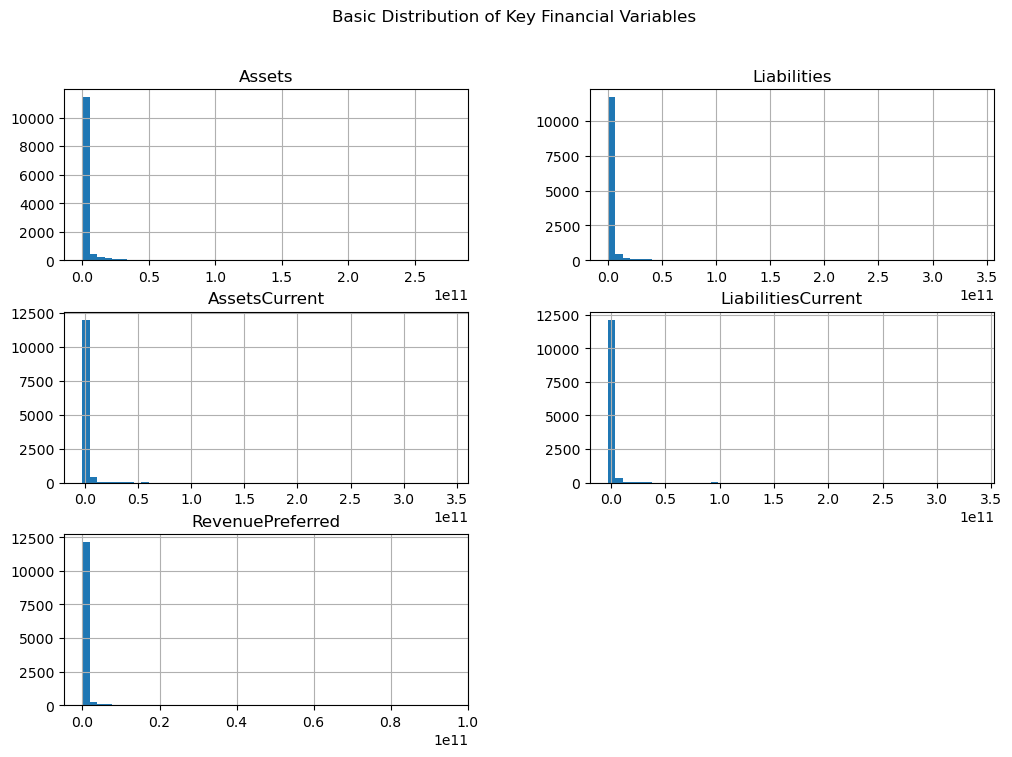

In [24]:
num_cols = ["Assets","Liabilities","AssetsCurrent","LiabilitiesCurrent","RevenuePreferred"]

df_fe[num_cols].hist(figsize=(12, 8), bins=50)
plt.suptitle("Basic Distribution of Key Financial Variables")
plt.show()


## 5.2 Boxplot

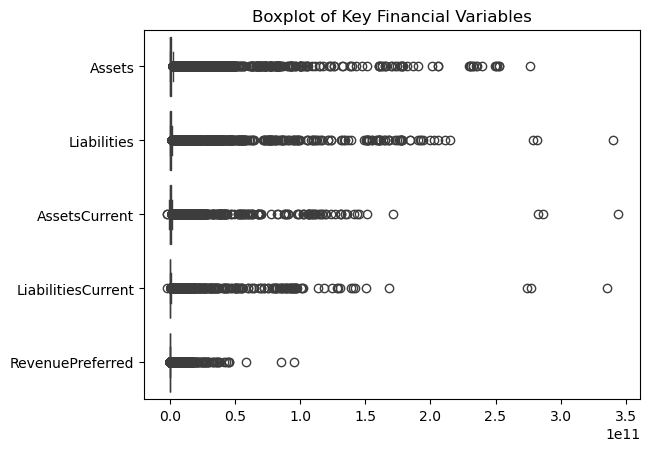

In [25]:
sns.boxplot(data=df_fe[num_cols], orient="h")
plt.title("Boxplot of Key Financial Variables")
plt.show()

In [26]:
df_fe["WorkingCapital"] = CA - CL
df_fe["CurrentRatio"]   = CA / CL
df_fe["QuickRatio"]     = (CA - INV) / CL

## 5.3 Ratio Distribution

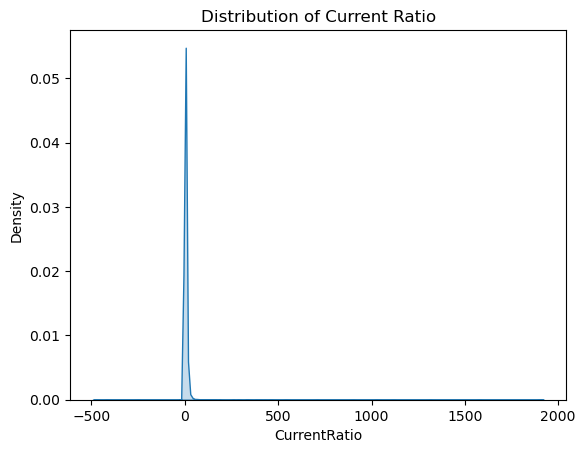

In [27]:
# Visuals
sns.kdeplot(df_fe["CurrentRatio"], fill=True)
plt.title("Distribution of Current Ratio")
plt.show()

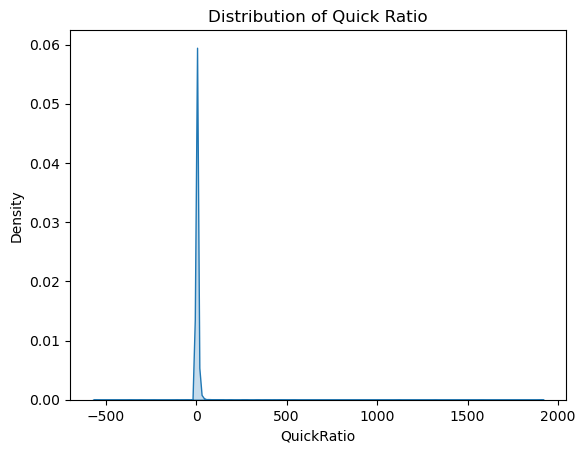

In [28]:
sns.kdeplot(df_fe["QuickRatio"], fill=True)
plt.title("Distribution of Quick Ratio")
plt.show()

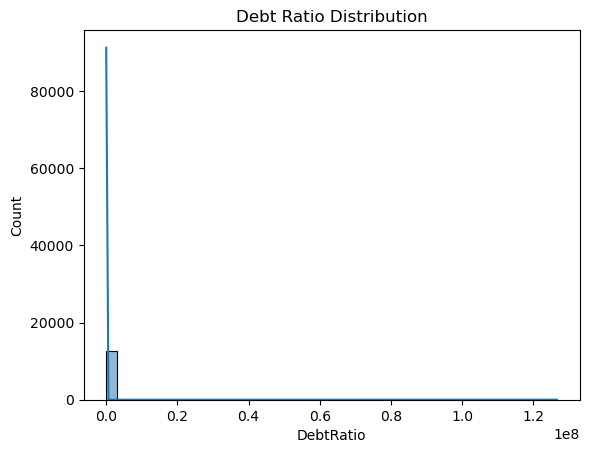

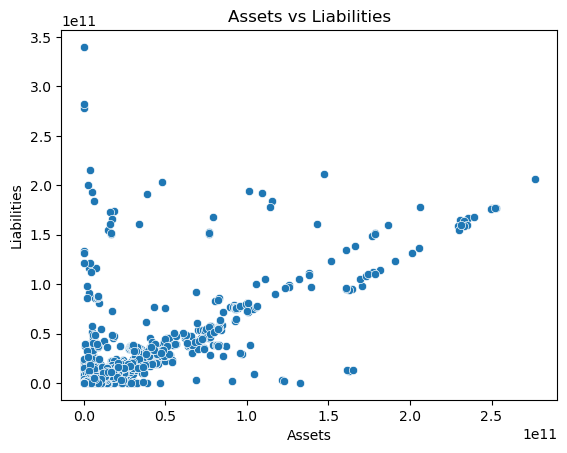

In [29]:
df_fe["DebtRatio"]         = L / A
df_fe["EquityRatio"]       = E / A
df_fe["LiabilityToAssets"] = L / A

# Visualisations
sns.histplot(df_fe["DebtRatio"], bins=40, kde=True)
plt.title("Debt Ratio Distribution")
plt.show()

sns.scatterplot(x=A, y=L)
plt.title("Assets vs Liabilities")
plt.xlabel("Assets")
plt.ylabel("Liabilities")
plt.show()

In [30]:
df_fe["NetMargin"]        = NI / REV
df_fe["OperatingMargin"]  = OI / REV
df_fe["ReturnOnAssets"]   = NI / A

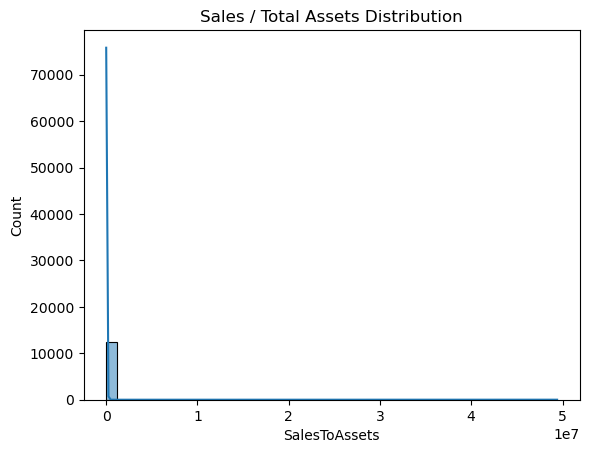

In [31]:
df_fe["SalesToAssets"]     = REV / A
df_fe["InventoryToAssets"] = INV / A

sns.histplot(df_fe["SalesToAssets"], kde=True, bins=40)
plt.title("Sales / Total Assets Distribution")
plt.show()

In [32]:
df_fe["WC_TA"]   = (CA - CL) / A
df_fe["RE_TA"]   = E / A
df_fe["EBIT_TA"] = OI.abs() / A
df_fe["Sales_TA"] = REV / A
df_fe["ME_TL"]   = E / L

df_fe["AltmanZ"] = (
    1.2 * df_fe["WC_TA"] +
    1.4 * df_fe["RE_TA"] +
    3.3 * df_fe["EBIT_TA"] +
    0.6 * df_fe["ME_TL"] +
    1.0 * df_fe["Sales_TA"]
)

## 5.4 Correlation Plot

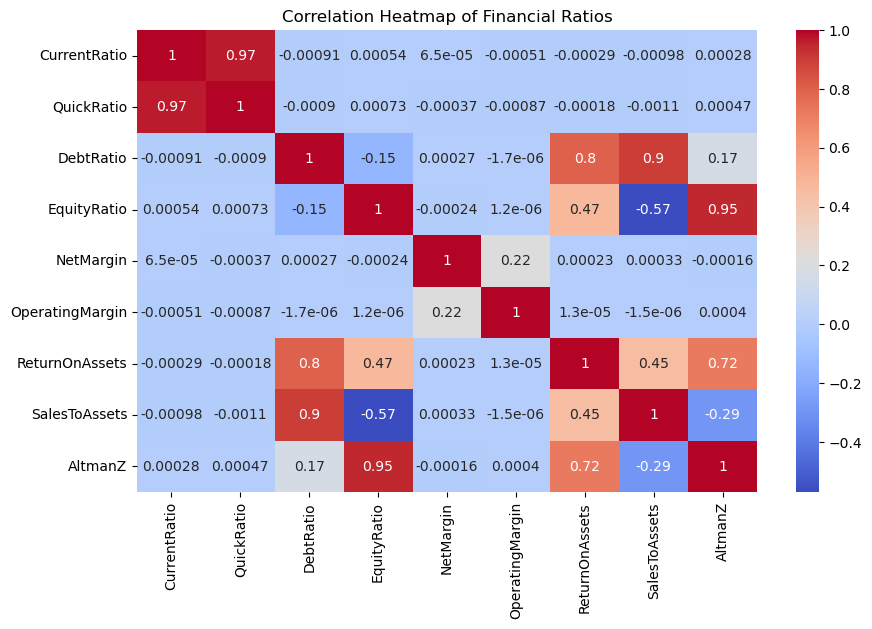

In [33]:
ratio_cols = [
    "CurrentRatio", "QuickRatio", "DebtRatio", "EquityRatio",
    "NetMargin", "OperatingMargin", "ReturnOnAssets",
    "SalesToAssets", "AltmanZ"
]

plt.figure(figsize=(10, 6))
sns.heatmap(df_fe[ratio_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Financial Ratios")
plt.show()

## 6 Imputing Financial Ratios

In [34]:
df_fe["InventoryNet"] = df_fe["InventoryNet"].fillna(0)
df_fe["InterestExpense"] = df_fe["InterestExpense"].fillna(0)

In [35]:
for col in ["Assets","Liabilities","Revenues","RevenuePreferred"]:
    df_fe[f"log_{col}"] = np.log1p(df_fe[col])

In [36]:
for col in ratio_cols:
    df_fe[col] = df_fe[col].clip(lower=df_fe[col].quantile(0.01),
                                 upper=df_fe[col].quantile(0.99))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [37]:
df_fe[ratio_cols].isna().sum()

CurrentRatio        10
QuickRatio           9
DebtRatio           14
EquityRatio          5
NetMargin          251
OperatingMargin     19
ReturnOnAssets      33
SalesToAssets      115
AltmanZ            138
dtype: int64

In [38]:
df_fe[ratio_cols] = df_fe[ratio_cols].fillna(df_fe[ratio_cols].median())

In [39]:
df_fe[ratio_cols].isna().sum()

CurrentRatio       0
QuickRatio         0
DebtRatio          0
EquityRatio        0
NetMargin          0
OperatingMargin    0
ReturnOnAssets     0
SalesToAssets      0
AltmanZ            0
dtype: int64

In [40]:
df_fe

,adsh,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,InterestExpense,InventoryNet,Liabilities,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,...,WC_TA,RE_TA,EBIT_TA,Sales_TA,ME_TL,AltmanZ,log_Assets,log_Liabilities,log_Revenues,log_RevenuePreferred
2,0000002969-20-000010,1.965160e+10,4.719700e+09,2.406100e+09,18700000.0,4.006000e+08,7.721800e+09,1.819000e+09,3.600000e+06,561000000.0,...,0.147606,0.588044,0.028547,0.051065,1.496542,2.043585,23.701425,22.767313,20.726760,20.726760
16,0000006951-20-000014,1.976700e+10,1.076900e+10,3.424000e+09,59000000.0,3.472000e+09,1.110700e+10,4.569000e+09,8.920000e+08,38000000.0,...,0.313654,-1.203825,0.001922,0.007740,-2.142433,-2.580345,23.707280,23.130841,18.845948,18.845948
27,0000008947-20-000012,5.097780e+08,4.146210e+08,1.428900e+07,10433000.0,0.000000e+00,5.193250e+08,1.823730e+08,2.203500e+07,86609000.0,...,0.455587,1.188254,0.169896,0.382643,1.166410,3.853405,20.049486,20.068040,19.088833,19.088833
44,0000016160-20-000011,1.111280e+09,4.488380e+08,1.124800e+07,0.0,1.909680e+08,1.769870e+08,1.028480e+08,-1.006100e+07,-80035000.0,...,0.311344,0.840230,0.072021,0.007016,5.275704,4.960041,20.828778,18.991587,15.869250,15.869250
45,0000016160-20-000056,1.117029e+09,4.453700e+08,6.775300e+07,0.0,1.914210e+08,1.689970e+08,8.966000e+07,1.374900e+07,-74823000.0,...,0.318443,0.848186,0.066984,0.017928,5.606301,5.172347,20.833938,18.945392,16.812542,16.812542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124360,0001980295-24-000021,2.548420e+05,1.012100e+04,1.012100e+04,0.0,0.000000e+00,2.753880e+05,2.753880e+05,-1.285600e+04,-29976.0,...,-1.040908,-0.226972,0.117626,0.039240,-0.210038,-1.265468,12.448403,12.525940,9.210440,9.210440
124367,0001993004-24-000102,6.256750e+09,3.684200e+08,2.527000e+06,0.0,1.215680e+08,5.037612e+09,8.132660e+08,-6.385000e+06,231625000.0,...,-0.071099,0.133636,0.037020,0.055172,0.165977,0.378697,22.556927,22.340198,19.659635,19.659635
124371,0001997652-24-000002,2.443506e+08,2.002076e+07,7.404200e+07,0.0,0.000000e+00,5.417899e+07,3.470636e+07,-5.894574e+06,-6978071.0,...,-0.060101,1.127895,0.028558,0.000000,5.086877,4.653299,19.314115,17.807804,0.000000,0.000000
124393,0002007919-24-000058,2.225620e+08,2.074460e+08,1.963320e+08,0.0,0.000000e+00,4.409500e+07,4.409500e+07,1.735437e+09,-46797000.0,...,0.733957,0.801875,0.210265,0.000449,4.047330,5.126096,19.220716,17.601857,11.512935,11.512935


## 7 Handling DateTime for filed Column and Target Variable Creation

In [41]:
# Make sure filed is datetime
df_fe["filed"] = pd.to_datetime(df_fe["filed"], format="%Y%m%d", errors="coerce")

# Sort by company (cik) and time
df_fe = df_fe.sort_values(["cik", "filed"])

# Create "next year" financials for each company
df_fe["next_equity"]      = df_fe.groupby("cik")["StockholdersEquity"].shift(-1)
df_fe["next_assets"]      = df_fe.groupby("cik")["Assets"].shift(-1)
df_fe["next_liabilities"] = df_fe.groupby("cik")["Liabilities"].shift(-1)

# New bankruptcy label: does the firm look distressed NEXT filing?
df_fe["Bankrupt"] = (
    (df_fe["next_equity"] < 0) |
    (df_fe["next_assets"] < df_fe["next_liabilities"]) |
    (df_fe["next_assets"].isna())   # disappeared / no next filing
).astype(int)

# Keep only rows where we HAVE a label
df_model = df_fe.dropna(subset=["Bankrupt"]).copy()

# Also keep the filing year for splitting
df_model["filed_year"] = df_model["filed"].dt.year

In [42]:
df_fe.head()

,adsh,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,InterestExpense,InventoryNet,Liabilities,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,...,ME_TL,AltmanZ,log_Assets,log_Liabilities,log_Revenues,log_RevenuePreferred,next_equity,next_assets,next_liabilities,Bankrupt
7338,0001213900-20-012418,16644000.0,10744000.0,79000.0,0.0,7655000.0,11243000.0,8831000.0,-2080000.0,-2019000.0,...,-1.956773,-2.243020,16.627560,16.235256,15.214228,15.214228,-885000.0,16625000.0,12325000.0,1
13171,0001213900-20-021747,16625000.0,10947000.0,465000.0,0.0,7207000.0,12325000.0,7429000.0,-1194000.0,-3127000.0,...,-0.071805,1.231064,16.626418,16.327140,15.879965,15.879965,28470000.0,13536000.0,10922000.0,0
19062,0001213900-20-036560,13536000.0,8201000.0,75000.0,0.0,5239000.0,10922000.0,6205000.0,-1787000.0,-1682000.0,...,2.606665,5.403745,16.420863,16.206290,15.243667,15.243667,-26182000.0,11908000.0,8418000.0,1
37397,0001213900-21-041828,11908000.0,7113000.0,344000.0,262000.0,3776000.0,8418000.0,5515000.0,1626000.0,-1480000.0,...,-3.110240,-4.008838,16.292721,15.945883,15.282924,15.282924,31078000.0,12130000.0,8375000.0,0
44138,0001213900-21-054196,12130000.0,7639000.0,271000.0,117000.0,4081000.0,8375000.0,5640000.0,-201000.0,-2183000.0,...,3.710806,7.574620,16.311192,15.940762,16.280300,16.280300,32175000.0,15279000.0,14342000.0,0


## 8 Winsorizing Columns containing Outliers

In [43]:
ratio_cols = [
    "CurrentRatio","QuickRatio","DebtRatio","EquityRatio",
    "NetMargin","OperatingMargin","ReturnOnAssets",
    "SalesToAssets","AltmanZ"
]

for col in ratio_cols:
    df_fe[col] = winsorize(df_fe[col], limits=[0.01, 0.01])

In [44]:
df_fe["Bankrupt"].value_counts(normalize=True)

Bankrupt
1    0.541466
0    0.458534
Name: proportion, dtype: float64

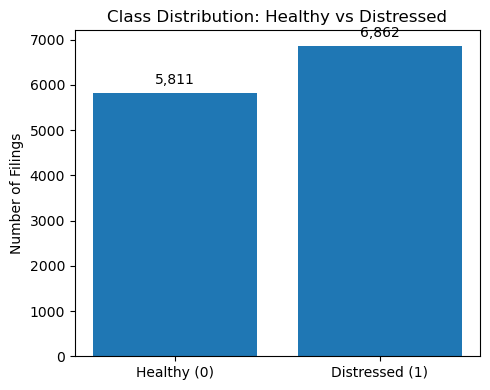

Proportions:
Bankrupt
0    0.458534
1    0.541466
Name: proportion, dtype: float64


In [45]:
# Class counts
class_counts = df_fe["Bankrupt"].value_counts().sort_index()
labels = ["Healthy (0)", "Distressed (1)"]
values = class_counts.values

plt.figure(figsize=(5, 4))
plt.bar(labels, values)
plt.title("Class Distribution: Healthy vs Distressed")
plt.ylabel("Number of Filings")
for i, v in enumerate(values):
    plt.text(i, v + 200, f"{v:,}", ha="center")
plt.tight_layout()
plt.show()

print("Proportions:")
print((class_counts / class_counts.sum()).rename("proportion"))

In [46]:
df_fe['filed'] = pd.to_datetime(df_fe['filed'], format="%Y%m%d", errors="coerce")

In [47]:
df_fe['filed_year'] = df_fe['filed'].dt.year

In [48]:
df_fe = df_fe[df_fe["filed_year"].between(2020, 2024)]

## 9 Train-Test Split

In [49]:
# Use only rows with valid year between 2020 and 2023
df_model = df_model[df_model["filed_year"].between(2020, 2023)]

# Train = 2020–2022, Test = 2023 (last year with future info)
train_df = df_model[df_model["filed_year"] < 2023].copy()
test_df  = df_model[df_model["filed_year"] == 2023].copy()

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print("Train bankrupt proportion:\n", train_df["Bankrupt"].value_counts(normalize=True))
print("Test bankrupt proportion:\n",  test_df["Bankrupt"].value_counts(normalize=True))

Train shape: (7753, 48)
Test  shape: (2554, 48)
Train bankrupt proportion:
 Bankrupt
1    0.507159
0    0.492841
Name: proportion, dtype: float64
Test bankrupt proportion:
 Bankrupt
1    0.522318
0    0.477682
Name: proportion, dtype: float64


In [50]:
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Train shape: (7753, 48)
Test  shape: (2554, 48)


In [51]:
print("Train bankrupt proportion:\n", train_df["Bankrupt"].value_counts(normalize=True))
print("Test bankrupt proportion:\n",  test_df["Bankrupt"].value_counts(normalize=True))

Train bankrupt proportion:
 Bankrupt
1    0.507159
0    0.492841
Name: proportion, dtype: float64
Test bankrupt proportion:
 Bankrupt
1    0.522318
0    0.477682
Name: proportion, dtype: float64


## 10 Feature Selection

In [52]:
# Ratios (you can add/remove if needed)
ratio_cols = [
    "CurrentRatio", "QuickRatio",
    "DebtRatio", "EquityRatio",
    "NetMargin", "OperatingMargin", "ReturnOnAssets",
    "SalesToAssets",
    "WC_TA", "RE_TA", "EBIT_TA", "Sales_TA", "ME_TL",
    "AltmanZ",
]

In [53]:
# Log-transformed scale features
log_cols = ["log_Assets", "log_Liabilities", "log_Revenues", "log_RevenuePreferred"]

feature_cols = ratio_cols + log_cols
target_col = "Bankrupt"

In [54]:
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].copy()

In [55]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test  = X_test.replace([np.inf, -np.inf], np.nan)

print("Any inf left in X_train? ->", np.isinf(X_train.to_numpy()).any())
print("Any inf left in X_test?  ->", np.isinf(X_test.to_numpy()).any())

Any inf left in X_train? -> False
Any inf left in X_test?  -> False


In [56]:
print("Feature matrix shape:", X_train.shape)

Feature matrix shape: (7753, 18)


## 11 Model Deployement

## 11.1 Logistic Regression

In [57]:
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    """Fit model and print metrics on test set."""
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    print(f"\n================ {name} ================")
    print(classification_report(y_te, y_pred, digits=3))
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        print("ROC AUC:", round(roc_auc_score(y_te, y_proba), 3))

In [58]:
log_reg_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # fills NaN with column median
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        n_jobs=-1
    )),
])

eval_model("Logistic Regression", log_reg_model, X_train, y_train, X_test, y_test)


================ Logistic Regression ================
              precision    recall  f1-score   support

           0      0.671     0.839     0.745      1220
           1      0.809     0.624     0.704      1334

    accuracy                          0.726      2554
   macro avg      0.740     0.731     0.725      2554
weighted avg      0.743     0.726     0.724      2554

ROC AUC: 0.772


## 11.2 XG Boost

In [59]:
# class imbalance handling for XGB: scale_pos_weight = (neg / pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

eval_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)


================ XGBoost ================
              precision    recall  f1-score   support

           0      0.683     0.864     0.763      1220
           1      0.836     0.633     0.720      1334

    accuracy                          0.743      2554
   macro avg      0.759     0.748     0.741      2554
weighted avg      0.763     0.743     0.740      2554

ROC AUC: 0.812


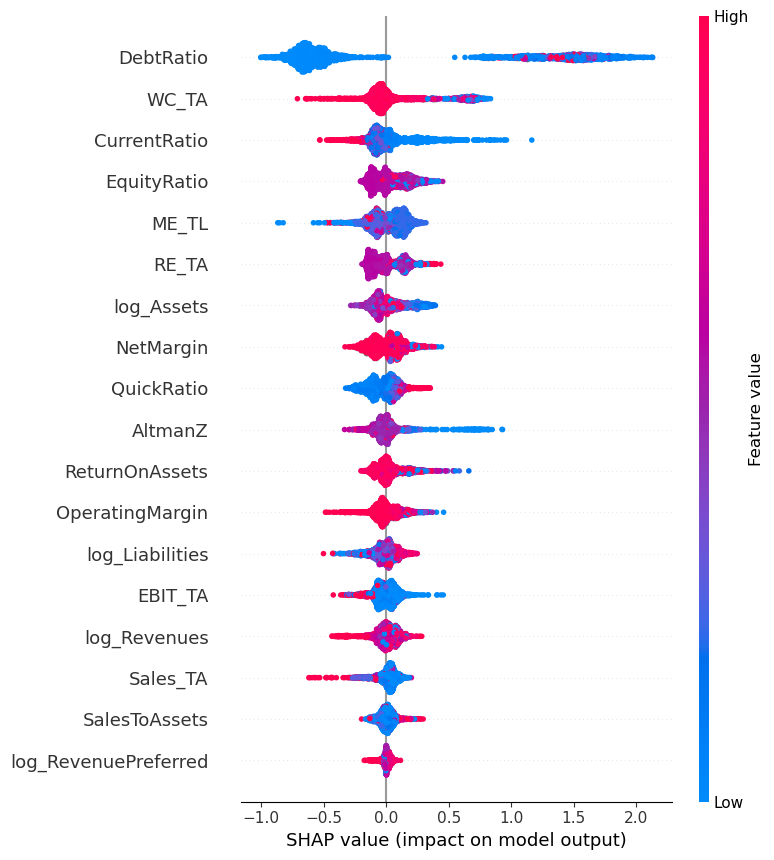

In [60]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [61]:
# add small noise to test set
X_noisy = X_test + np.random.normal(0, 0.01, X_test.shape)

y_pred_clean = xgb_model.predict(X_test)
y_pred_noisy = xgb_model.predict(X_noisy)

accuracy_drop = (y_pred_clean != y_pred_noisy).mean()
print("Robustness Score :", accuracy_drop)

Robustness Score : 0.025450274079874706


## 11.3 Random Forest Classifier

In [62]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

eval_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)


================ Random Forest ================
              precision    recall  f1-score   support

           0      0.692     0.834     0.756      1220
           1      0.813     0.660     0.729      1334

    accuracy                          0.743      2554
   macro avg      0.752     0.747     0.742      2554
weighted avg      0.755     0.743     0.742      2554

ROC AUC: 0.813


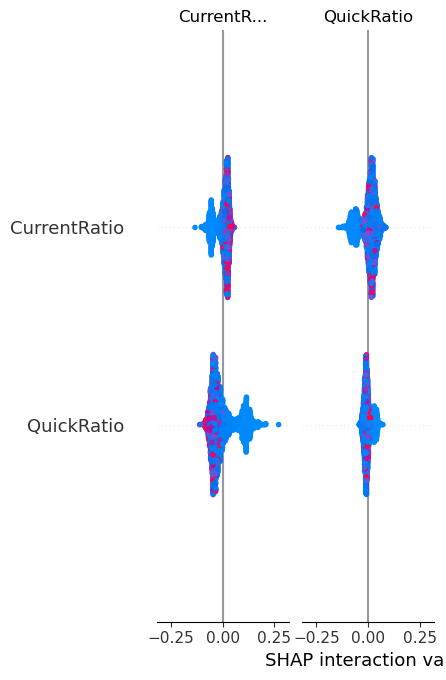

In [63]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [64]:
# 1. Remove inf values by converting them to NaN
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan)
X_test_clean  = X_test.replace([np.inf, -np.inf], np.nan)

# 2. Impute NaNs with median (like we did in scikit pipelines)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_clean)
X_test_imp  = imputer.transform(X_test_clean)

# 3. Scale features (DNNs work MUCH better when inputs are standardised)
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_imp)
X_test_np  = scaler.transform(X_test_imp)

print("Any NaN left in X_train_np? ->", np.isnan(X_train_np).any())
print("Any NaN left in X_test_np?  ->", np.isnan(X_test_np).any())

Any NaN left in X_train_np? -> False
Any NaN left in X_test_np?  -> False


## 11.4 Multi layer Perceptron

In [65]:
mlp_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        max_iter=200,
        random_state=42
    )),
])

eval_model("MLP Neural Network", mlp_model, X_train, y_train, X_test, y_test)


================ MLP Neural Network ================
              precision    recall  f1-score   support

           0      0.682     0.856     0.759      1220
           1      0.828     0.636     0.719      1334

    accuracy                          0.741      2554
   macro avg      0.755     0.746     0.739      2554
weighted avg      0.758     0.741     0.738      2554

ROC AUC: 0.791


In [66]:
dnn_model = models.Sequential()
dnn_model.add(layers.Input(shape=(X_train_np.shape[1],)))
dnn_model.add(layers.Dense(128, activation='relu'))
dnn_model.add(layers.Dropout(0.2))
dnn_model.add(layers.Dense(64, activation='relu'))
dnn_model.add(layers.BatchNormalization())
dnn_model.add(layers.Dense(32, activation='relu'))
dnn_model.add(layers.Dense(1, activation='sigmoid'))

In [67]:
## 11.5 Deep Neural Network

In [68]:
dnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = dnn_model.fit(
    X_train_np, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - AUC: 0.6618 - loss: 0.6566 - val_AUC: 0.7207 - val_loss: 0.6371
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - AUC: 0.7239 - loss: 0.6010 - val_AUC: 0.7352 - val_loss: 0.5966
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - AUC: 0.7420 - loss: 0.5862 - val_AUC: 0.7246 - val_loss: 0.6012
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - AUC: 0.7467 - loss: 0.5716 - val_AUC: 0.7325 - val_loss: 0.6017
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - AUC: 0.7587 - loss: 0.5663 - val_AUC: 0.7322 - val_loss: 0.5777
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - AUC: 0.7516 - loss: 0.5668 - val_AUC: 0.7383 - val_loss: 0.5729
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - AUC: 0.7561 - loss: 0.5636 - val_AUC: 0.7476 - val_loss: 0.5717
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - AUC: 0.7748 - loss: 0.5474 - val_AUC: 0.7447 - val_loss: 0.5642
Epoch 9/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 

In [69]:
y_proba_dnn = dnn_model.predict(X_test_np).ravel()
y_pred_dnn = (y_proba_dnn >= 0.5).astype(int)

print("\n================ DNN (cleaned) ================")
print(classification_report(y_test, y_pred_dnn, digits=3))

print("DNN ROC AUC:", round(roc_auc_score(y_test, y_proba_dnn), 3))

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step

================ DNN (cleaned) ================
              precision    recall  f1-score   support

           0      0.679     0.885     0.768      1220
           1      0.855     0.617     0.717      1334

    accuracy                          0.745      2554
   macro avg      0.767     0.751     0.742      2554
weighted avg      0.771     0.745     0.741      2554

DNN ROC AUC: 0.779


Logistic Regression AUC (test, cleaned): 0.772
Random Forest AUC (test, cleaned): 0.813
XGBoost AUC (test, cleaned): 0.812
MLP Neural Network AUC (test, cleaned): 0.791
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
DNN AUC (test, cleaned): 0.779


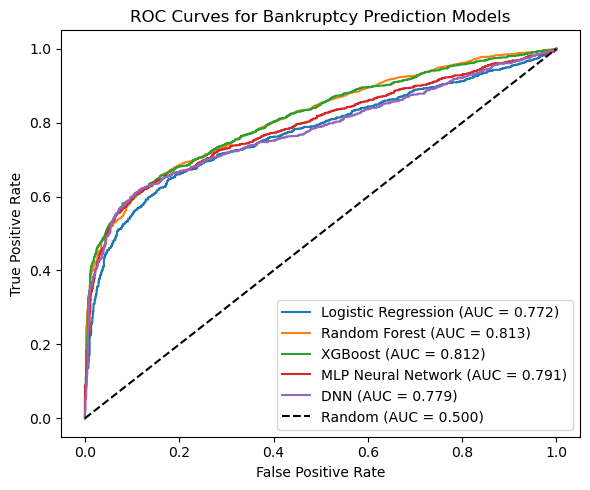

In [74]:
# If not already defined for DNN:
# X_test_np = X_test.values.astype(float)

models = {
    "Logistic Regression": log_reg_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "MLP Neural Network": mlp_model,
    "DNN": dnn_model,
}

plt.figure(figsize=(6, 5))

for name, model in models.items():
    # --- 1) Get scores ---
    if name == "DNN":
        # Keras model
        y_score = model.predict(X_test_np).ravel()
    else:
        # Sklearn models
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            # fallback if no predict_proba (not needed here, but safe)
            y_score = model.decision_function(X_test)

    # --- 2) Clean scores (remove NaN / inf, same idea as your "cleaned" DNN) ---
    y_score = np.array(y_score, dtype=float)
    mask = np.isfinite(y_score)

    y_true_clean = y_test[mask]
    y_score_clean = y_score[mask]

    # --- 3) Compute AUC and ROC using the cleaned scores ---
    auc = roc_auc_score(y_true_clean, y_score_clean)
    fpr, tpr, _ = roc_curve(y_true_clean, y_score_clean)

    print(f"{name} AUC (test, cleaned): {auc:.3f}")
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# --- 4) Random baseline ---
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.500)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Bankruptcy Prediction Models")
plt.legend()
plt.tight_layout()
plt.show()